# TODO
- need all cells (ie non-MEL) to make argument for SC vs BULK analysis from Ashley
- need annotation criteria from Ryan
- plot MITF vs SOX2 over developmental time
- Better comparison to fetal expression??? Is there a more elegant way to show similarities? Perhaps, heat map of top DE genes?
- enumerate TFs in each path


# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
# for file in ['adata_all']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
#     var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
#     exec(f'{file} = var')
#     del var


scanpy version: 1.3.3


In [2]:
# FUNCTIONS
from collections import defaultdict
import multiprocessing

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=None, max_mean=None, min_disp=None):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

## Ingest data

Principle component analysis...


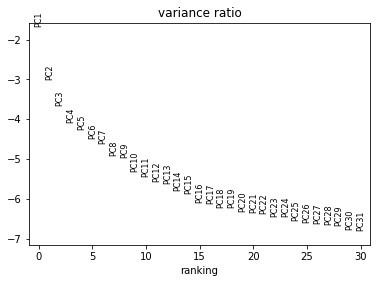

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
resolution(res): 0.75


... storing 'Phase' as categorical
... storing 'res_0_1' as categorical
... storing 'res_0_3' as categorical
... storing 'res_0_5' as categorical
... storing 'res_0_7' as categorical
... storing 'res_0_9' as categorical
... storing 'sample' as categorical


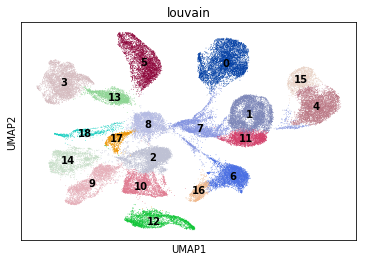

In [27]:
# all cells
run_me = True

if run_me == True:

    ### TRUNK ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/tiss_d0_filtered.h5ad'
    adata_d0 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/tiss_d6_filtered.h5ad'
    adata_d6 = ad.read_h5ad(filename)

    # concat
    adata_trunk = adata_d0.concatenate(adata_d6, join='outer')

    # update meta data with path and day
    adata_trunk.obs['path'] = 'trunk'
    adata_trunk.obs['day'] = [int(x.split('d')[-1]) for x in adata_trunk.obs['sample']]


    ### DIRECT ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/tiss_d15_dirV2_filtered.h5ad'
    adata_dir_d15 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/dir_D22_only.h5ad'
    adata_dir_d22 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/dir_D30_only.h5ad'
    adata_dir_d30 = ad.read_h5ad(filename)

    # concat
    adata_dir = adata_dir_d15.concatenate(adata_dir_d22, adata_dir_d30, join='outer')

    # update meta data with path and day
    adata_dir.obs['path'] = 'direct'
    adata_dir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_dir.obs['sample']]


    ### INDIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/all_cells/tiss_d15_d59_indir.h5ad'
    adata_indir = ad.read_h5ad(filename)

    # update meta data with path and day
    adata_indir.obs['path'] = 'indirect'
    adata_indir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_indir.obs['sample']]


    ### ALL ###

    # merge all
    adata_all = adata_trunk.concatenate(adata_dir, adata_indir, join='outer')

    # update categorical path
    adata_all.obs['path'] = adata_all.obs['path'].astype(str).astype(CategoricalDtype(['indirect','direct','trunk']))

    # freeze raw counts and scale
    adata_all.raw = adata_all
     
    # log transform, prune on dispersion, scale
    sc.pp.log1p(adata_all)
    sc.pp.highly_variable_genes(adata_all)
    sc.pp.scale(adata_all)

    # UMAP and PCA
    input_adata = adata_all
    pca_adata(input_adata, num_pcs=30)
    umap_adata(input_adata, res=0.75, scan = False)

#     # pickle adatas
#     for objname in ['adata_all']:
#         pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
#         syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
#         subprocess.run(syscmd.split(' '))


## Module scoring for annotations


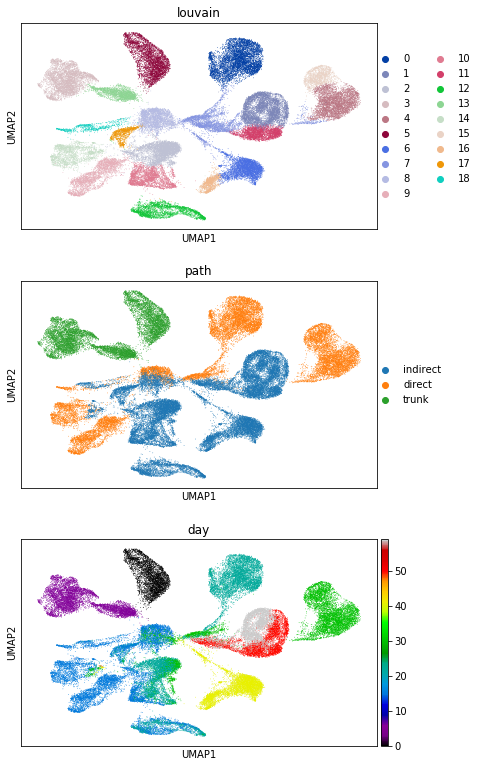

In [31]:
cycling_module = ['TOP2A','CDK1','UBE2C',
                  'HIST1H4E','HIST1H4C'] # ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf
CNS_neuronal_precursors = ['SIX3','PAX6','FEZF1',
                           'DLK1','HESX1','LHX5',
                           'LMO1','EMX2','ARX']
ESC = ['DNMT3B','NANOG','POU5F1','SOX2']
low_quality = ['ACTB','GAPDH','RPL7','RPS27A']
neural_crest_precursors = ['SOX10','FOXD3','WNT1',
                           'SNAI2','SOX9','PAX3']
ectoderm_fibroblast = ['GATA3','EPCAM','KRT18',
                       'KRT19','CD9','CLDN6']
trigeminal_placode_ganglia = ['SST','ISL1','SIX1',
                              'POU4F1','NEFM']
cranial_placode = ['PAX6','BMP4','RBFOX1','CD82']
CNS_precursors = ['FRZB','NEFM','MSX1','MSX2','CDH11']

test_adata = adata_all
test_adata.obs['cell'] = test_adata.obs.index.tolist()
test_adata.obs['cell'] = (test_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = genesOI,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene
test_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
test_adata.obs['CNS_neuronal_precursors'] = exp_df.loc[:,CNS_neuronal_precursors].mean(axis=1)
test_adata.obs['ESC'] = exp_df.loc[:,ESC].mean(axis=1)
test_adata.obs['low_quality'] = exp_df.loc[:,low_quality].mean(axis=1)
test_adata.obs['neural_crest_precursors'] = exp_df.loc[:,neural_crest_precursors].mean(axis=1)
test_adata.obs['ectoderm_fibroblast'] = exp_df.loc[:,ectoderm_fibroblast].mean(axis=1)
test_adata.obs['trigeminal_placode_ganglia'] = exp_df.loc[:,trigeminal_placode_ganglia].mean(axis=1)
test_adata.obs['cranial_placode'] = exp_df.loc[:,cranial_placode].mean(axis=1)
test_adata.obs['CNS_precursors'] = exp_df.loc[:,CNS_precursors].mean(axis=1)

genesOI = list(set(cycling_module + CNS_neuronal_precursors + ESC + low_quality + neural_crest_precursors +
                                ectoderm_fibroblast + trigeminal_placode_ganglia + cranial_placode + CNS_precursors))
[x for x in genesOI if x not in adata_all.var_names]

sc.pl.umap(adata_all, color = ['louvain','path','day'], cmap = 'nipy_spectral', ncols = 1)



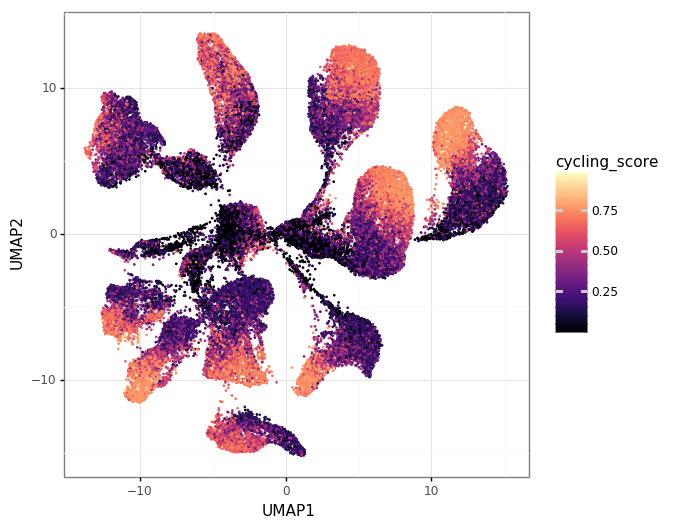

<ggplot: (-9223363254142544468)>


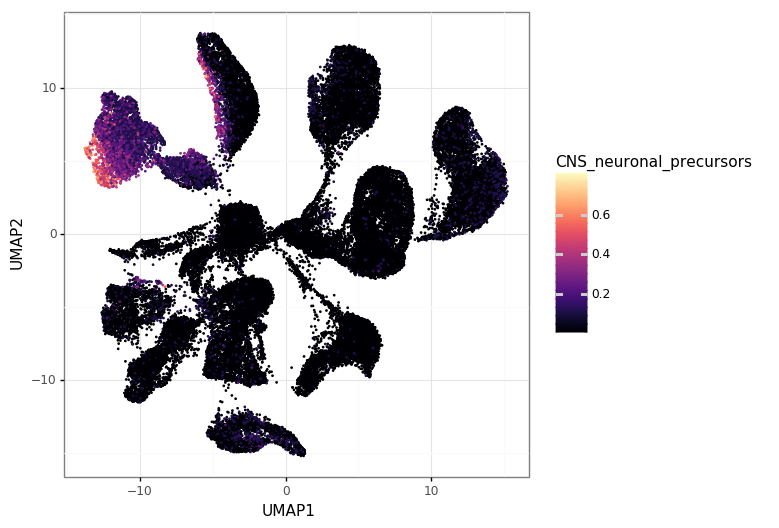

<ggplot: (-9223363254216957959)>


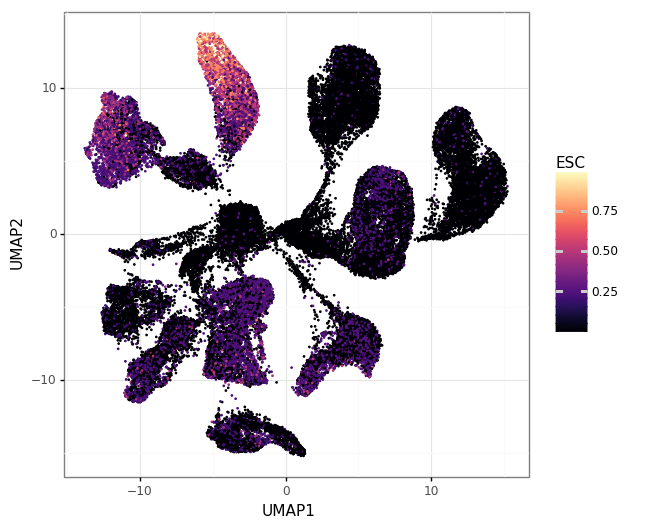

<ggplot: (-9223363254214720063)>


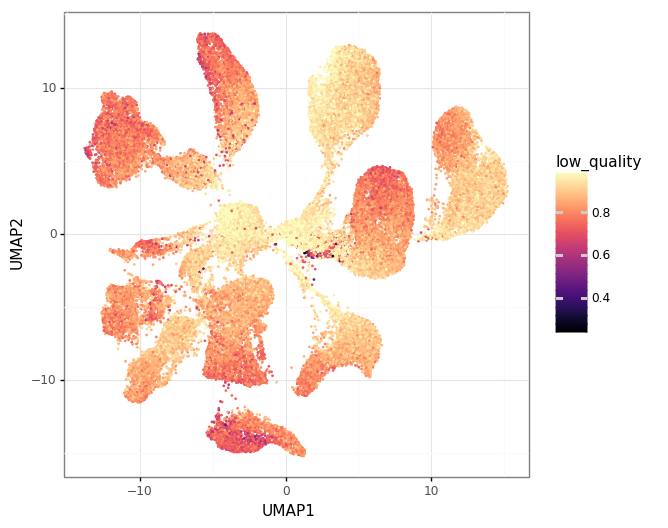

<ggplot: (8782621009514)>


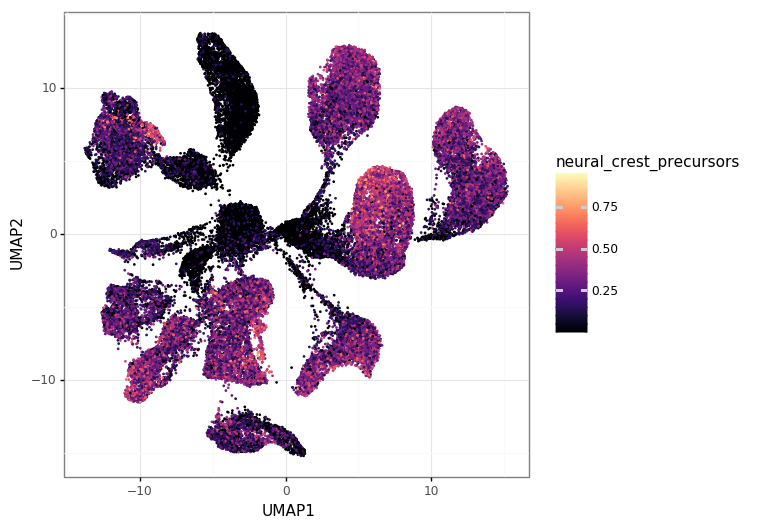

<ggplot: (-9223363254216264893)>


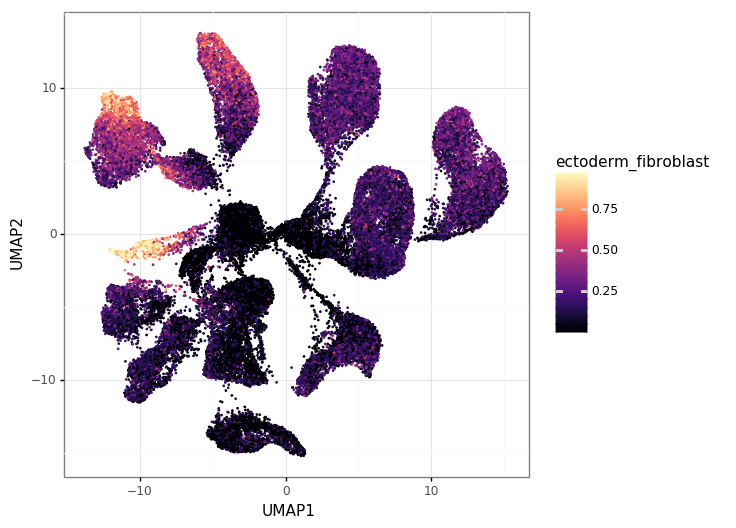

<ggplot: (8782637814799)>


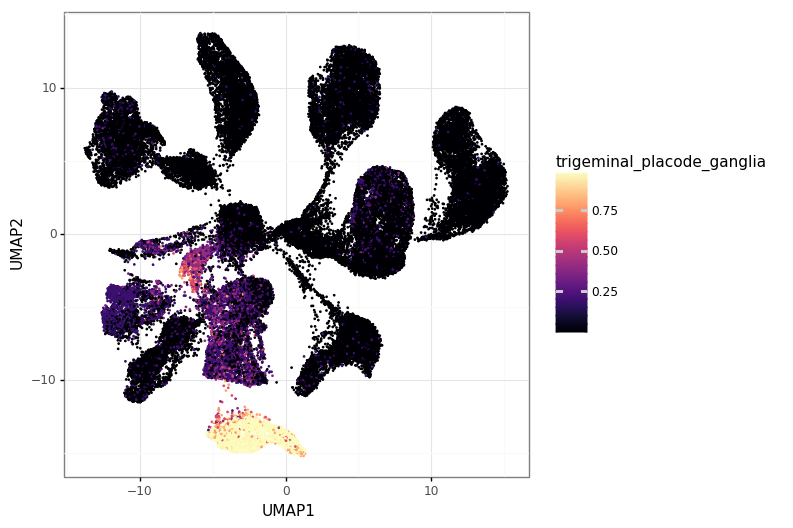

<ggplot: (-9223363254214658549)>


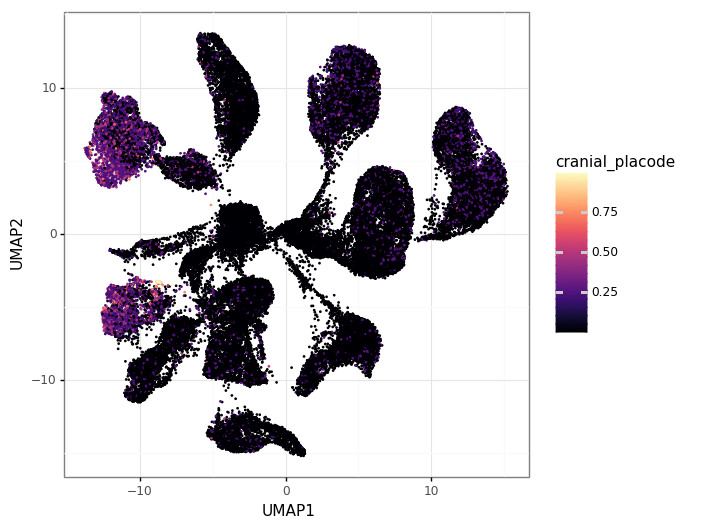

<ggplot: (8782639995347)>


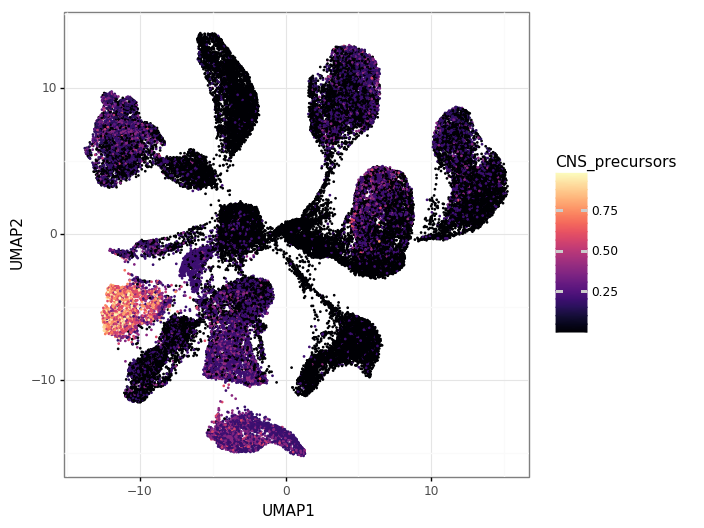

<ggplot: (8782621265216)>


In [30]:
targets = ['cycling_score', 'CNS_neuronal_precursors', 'ESC', 
           'low_quality','neural_crest_precursors','ectoderm_fibroblast',
           'trigeminal_placode_ganglia', 'cranial_placode', 'CNS_precursors'
          ]
for target in targets:
    plot_df = pd.DataFrame(adata_all.obsm.X_umap)
    plot_df.columns = ['UMAP1','UMAP2']
    plot_df[target] = adata_all.obs[target].values.tolist()

    plotnine.options.figure_size = (6,6)
    print(ggplot(plot_df)
          + theme_bw()
          + theme(aspect_ratio = 1)
          + geom_point(aes('UMAP1','UMAP2', color = target), size = 0.1)
          + scale_color_cmap('magma')
         )

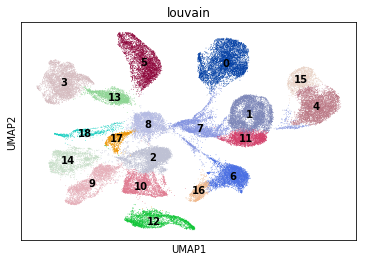

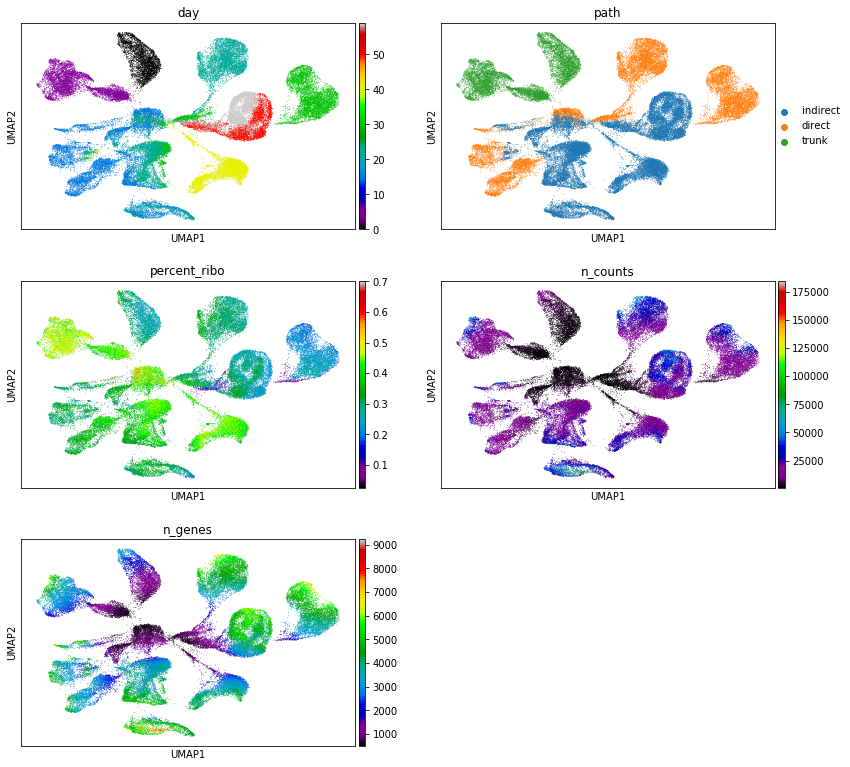

In [51]:
sc.pl.umap(adata_all, color = ['louvain'], legend_loc = 'on data')
sc.pl.umap(adata_all, color = ['day','path','percent_ribo',
                               'n_counts','n_genes'], 
           cmap = 'nipy_spectral', ncols = 2)



In [49]:
adata_all

AnnData object with n_obs × n_vars = 55050 × 26577 
    obs: 'G2M_Score', 'Phase', 'S_Score', 'batch', 'day', 'n_counts', 'n_genes', 'orig_ident', 'path', 'percent_ribo', 'res_0_1', 'res_0_3', 'res_0_5', 'res_0_7', 'res_0_9', 'sample', 'louvain', 'cell', 'cycling_score', 'CNS_neuronal_precursors', 'ESC', 'low_quality', 'neural_crest_precursors', 'ectoderm_fibroblast', 'trigeminal_placode_ganglia', 'cranial_placode', 'CNS_precursors', 'annotation'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'path_colors', 'annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'annotation' as categorical


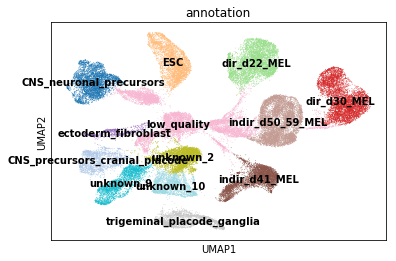

In [56]:
# manual annotations

## create dictionary
cluster2anno = {'5':'ESC',
                '14':'CNS_precursors_cranial_placode',
                '12':'trigeminal_placode_ganglia',
                '18':'ectoderm_fibroblast',
                '15':'dir_d30_MEL',
                '4':'dir_d30_MEL',
                '1':'indir_d50_59_MEL',
                '11':'indir_d50_59_MEL',
                '0':'dir_d22_MEL',
                '6':'indir_d41_MEL',
                '16':'indir_d41_MEL',
                '3':'CNS_neuronal_precursors',
                '13':'low_quality',
                '8':'low_quality',
                '17':'low_quality',
                '7':'low_quality',
               }

### update dict with unknown cluster label
for x in [x for x in set(adata_all.obs.louvain) if x not in [key for key,value in cluster2anno.items()]]:
    cluster2anno[x] = f'unknown_{x}'
    
adata_all.obs['annotation'] = adata_all.obs['louvain'].map(cluster2anno)

sc.pl.umap(adata_all, color = ['annotation'], palette = 'tab20', 
          legend_loc = 'on data')

    

In [ ]:
# dir_d15 MEL precursor = SOX2+/MITF+
# indir_d41 MEL precursor = SOX2+/MITF+
# indir_d15_22_30 uncommitted = SOX2+/MITF-

sc.pl.umap(adata_all, color = ['TYR','MITF','SOX2','PLP1'], 
           cmap = 'nipy_spectral', ncols = 1)


# PCA

In [ ]:
# sanity check
sc.pl.umap(adata_all, color = ['path', 'day','louvain'], palette = 'tab20', cmap = 'nipy_spectral')

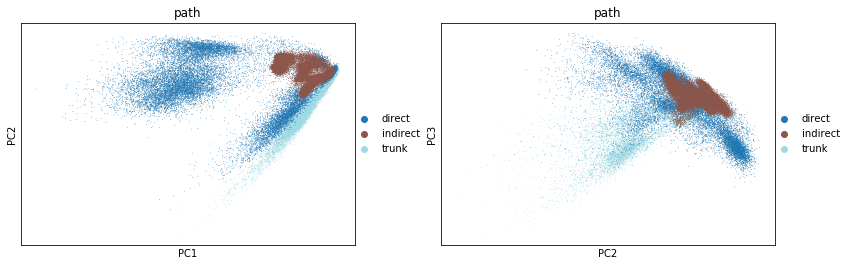

indirect


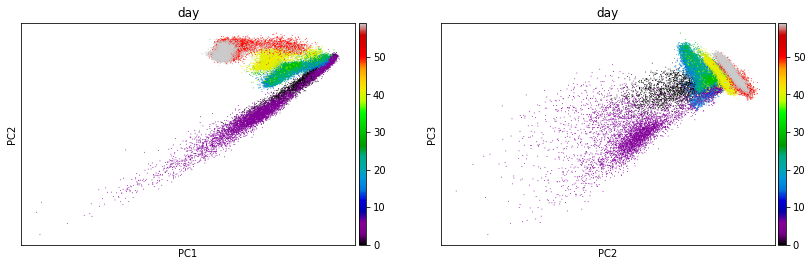

direct


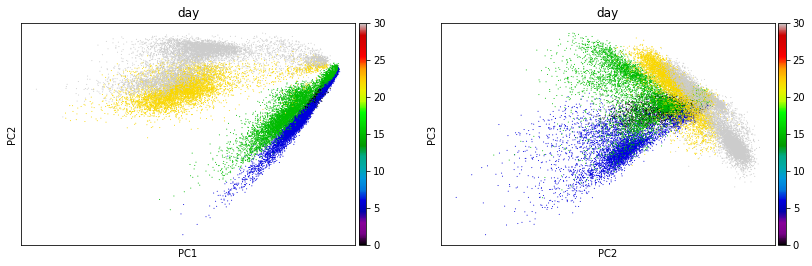

In [26]:
components = ['1,2','2,3']
sc.pl.pca(adata_all, color = ['path'], components=components, palette = 'tab20')
print('indirect')
sc.pl.pca(adata_all[adata_all.obs.path != 'direct'], color = ['day'], components=components, cmap = 'nipy_spectral')
print('direct')
sc.pl.pca(adata_all[adata_all.obs.path != 'indirect'], color = ['day'], components=components, cmap = 'nipy_spectral')



# Differential expression: path-specific terminally-differentiated

## Bulkized ranked correlation

### All-clusters correlation

In [ ]:
cat, adata_louvain_df = prepare_dataframe(adata_all,
                                         adata_all.var_names.tolist(),
                                        'louvain',
                                         use_raw = True)
cluster_labels = {'0':'indir_d50_59',
                  '1':'indir_d15_22_30',
                  '2':'dir_d30',
                  '3':'dir_d22',
                  '4':'indir_d41',
                  '5':'trunk_d6',
                  '6':'truck_d0',
                  '7':'dir_d15'
                 }
corr_df = (adata_louvain_df
           .reset_index()
           .groupby('louvain')
           .mean()
           .T
           .rename(columns = cluster_labels)
          )

plot_df = corr_df.corr('spearman').reset_index().rename(columns = {'louvain':'cluster'})
plot_df = pd.melt(plot_df, id_vars='cluster')
plot_df['label'] = [round(x,2) for x in plot_df.value]

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','louvain',fill='value'))
      + geom_text(aes('cluster','louvain',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('Variance explained')
     )

#### Only terminally-differentiated clusters

In [ ]:
adata_dir_d30 = adata_all[[x == 30 and y == 'direct' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
adata_indir_d50_59 = adata_all[[x >= 50 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_dir_d30.var_names) & set(adata_indir_d50_59.var_names))

cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)

# bulkized correlation
stat, pval = stats.spearmanr(adata_dir_d30_df.mean().values, adata_indir_d50_59_df.mean().values)
print('variance explained:', stat**2)
plot_df = pd.DataFrame({'direct': adata_dir_d30_df.mean().values,
                        'indirect': adata_indir_d50_59_df.mean().values
                       })
print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes('direct', 'indirect'))
      + scale_y_log10()
      + scale_x_log10()
     )


## Single-cell ranked location test

In [ ]:
for i in ['greater', 'less']:
    print(f'direct {i} than indirect:')
    if i == 'greater':
        ascending = False
    else:
        ascending = True
    stat_pval_tuple = parallel_mwu(genes, 
                                   adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                                   adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                                   i, 
                                   7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    mwu_pathspecific = (pd.DataFrame({'gene':genes,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
              )

    display(mwu_pathspecific.dropna().sort_values('stat_1', ascending = ascending).head(10))

In [ ]:
gene = 'SPTBN1'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       }).append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                               'variable':'indir_d50_59'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Comparison to primary melanocytes

## Bulkized ranked correlation

In [ ]:
## read in adata with fetal melanocytes = adata_subset2
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
for file in ['adata_subset2']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

adata_subset2.obs['dev_stage'] = ['adt' if x > 0 else 'neo' if x == 0 else 'fet' for x in adata_subset2.obs.age]
adata_subset2.obs['subtypes'] = [x if x in ['acral','foreskin'] else 'cutaneous' for x in adata_subset2.obs.general_location]
adata_subset2.obs['dev_subtype'] = [f'{x}_{y}' for x,y in zip(adata_subset2.obs.dev_stage, adata_subset2.obs.subtypes)]


In [ ]:
# bulk-ize terminal direct and indirect...spearman correlation to bulkized fetal
genes = list(set(adata_subset2.var_names) & set(adata_all.var_names))
input_adata = adata_subset2

# create expression vector for dir path
cat, adata_dir_d30_df = prepare_dataframe(adata_dir_d30,
                                         genes,
                                        'path',
                                         use_raw = True)
adata_dir_d30_vec = adata_dir_d30_df.mean().values
    
# create expression vector for indir path
cat, adata_indir_d50_59_df = prepare_dataframe(adata_indir_d50_59,
                                         genes,
                                        'path',
                                         use_raw = True)
adata_indir_d50_59_vec = adata_indir_d50_59_df.mean().values

path_list = []
devtype_list = []
stat_list = []
for i in list(set(adata_subset2.obs.dev_subtype)):
    input_adata = adata_subset2[adata_subset2.obs.dev_subtype == i]
    
    # create expression vector for primary
    cat, adata_subset2_df = prepare_dataframe(input_adata,
                                             genes,
                                            'patient',
                                             use_raw = True)
    adata_subset2_vec = adata_subset2_df.mean().values
    
    for j in [adata_dir_d30_vec, adata_indir_d50_59_vec]:
        if j is adata_dir_d30_vec:
            path = 'dir'
        else:
            path = 'indir'
        stat, pval = stats.spearmanr(adata_subset2_vec, j)
        path_list.append(path)
        devtype_list.append(i)
        stat_list.append(stat)
        
plot_df = pd.DataFrame({'dish_path':path_list,
                        'primary_type':devtype_list,
                        'rho':stat_list
                       })
plot_df['variance_explained'] = plot_df.rho**2
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_bar(aes('primary_type','variance_explained',fill='dish_path'), 
                 stat = 'identity', 
                 position = 'dodge')
      + ylim((0,1))
     )


##  Single cell ranked location test

In [ ]:
### refactor for different primary tissues ###
# dev_stage = 'adt'
# dev_stage = 'neo'
dev_stage = 'fet'
print(f'Primary melanocyte developmental state: {dev_stage}')

primary_adata = adata_subset2[adata_subset2.obs.dev_stage == dev_stage]
genes = list(set(primary_adata.var_names) & set(mwu_pathspecific.gene))
cat, primary_slice = prepare_dataframe(primary_adata,
                                     var_names = genes,
                                     groupby = 'patient')

alpha = 0.05
adj_alpha = alpha / (len(genes) * 2)

for test in ['greater', 'less']:
    print(f'direct {test} than indirect:')
    if test == 'greater':
        ascending = False
    else:
        ascending = True
    
    # stat_1 = direct vs indirect
    stat_pval_tuple = parallel_mwu(genes, 
                                   adata_dir_d30_df.rank(pct=True, axis = 1, method = 'min'), 
                                   adata_indir_d50_59_df.rank(pct=True, axis = 1, method = 'min'), 
                                   test, 
                                   7)
    stat_list = stat_pval_tuple[0]
    pval_list = stat_pval_tuple[1]
    mwu_pathspecific = (pd.DataFrame({'gene':genes,
                             'stat_1':stat_list,
                             'pval_1':pval_list
                            })
              )
    
    # stat_2 = direct vs primary OR indirect vs primary
    path_specific_df = pd.DataFrame()
    for path in ['direct', 'indirect']:
        if path == 'direct':
            slice_df = adata_dir_d30
        elif path == 'indirect':
            slice_df = adata_indir_d50_59
        cat, prep_slice = prepare_dataframe(slice_df,
                                         var_names = genes,
                                         groupby = 'path')

        stat_pval_tuple = parallel_mwu(genes, 
                                   primary_slice.rank(pct=True, axis = 1, method = 'min'), 
                                   prep_slice.rank(pct=True, axis = 1, method = 'min'), 
                                   test,
                                   7)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        tmp_df = (pd.DataFrame({'gene':genes,
                                 'stat_2':stat_list,
                                 'pval_2':pval_list
                                })
                  )
        tmp_df['path'] = path
        tmp_df['pass'] = [x < adj_alpha for x in tmp_df['pval_2']]
        path_specific_df = path_specific_df.append(tmp_df)

    path_specific_df = pd.merge(mwu_pathspecific, path_specific_df, 'left', 'gene')
    path_specific_df = path_specific_df.dropna().sort_values('stat_1', ascending=ascending)
    keep_genes = path_specific_df.groupby('gene')['pass'].sum()
    keep_genes = keep_genes[keep_genes == 1].index.tolist()
    path_specific_df = path_specific_df[[x in keep_genes for x in path_specific_df.gene]]
    display(path_specific_df.head(10))


In [ ]:
###### gene lookup

gene = 'FXYD5'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = (pd.DataFrame({'value':adata_dir_d30_df[gene].values,
                        'variable':'dir_d30'
                       })
           .append(pd.DataFrame({'value':adata_indir_d50_59_df[gene].values,
                                 'variable':'indir_d50_59'
                                              }))
           .append(pd.DataFrame({'value':primary_slice[gene].values,
                                 'variable':dev_stage
                                  }))
           
                        )

point_df = pd.DataFrame(plot_df[plot_df['variable'] != dev_stage].groupby('variable').mean())
point_df[dev_stage] = primary_slice.loc[:,gene].mean()
point_df = point_df.reset_index()

bulkize_df = pd.DataFrame({dev_stage:primary_slice.mean().values, 
                          'dir_d30':adata_dir_d30_vec,
                          'indir_d50_59':adata_indir_d50_59_vec})
bulkize_df = pd.melt(bulkize_df, id_vars=dev_stage)

plotnine.options.figure_size = (5,5)
print(ggplot()
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_bin2d(bulkize_df, aes(dev_stage,'value'))
      + geom_point(point_df, aes(dev_stage, 'value'), color = 'red')
      + facet_wrap('~variable')
      + scale_x_log10()
      + scale_y_log10()
     )

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# DEV: velocyto

In [ ]:
import loompy
import os
import scvelo as scv

In [ ]:
run = False

filedir = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/'
files = [''.join([filedir,x]) for x in os.listdir(filedir) if (x.endswith('.loom') and x != 'merged.loom')]
for x in files:
    print(x)

filename = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/merged.loom'
if run == True:
    loompy.combine(files,filename,"Accession")


In [ ]:
# garbage collection
del fltrd_velo, adata, adata_velo_merge
import gc
gc.collect()

In [ ]:
adata = scv.read(filename, cache=True)
adata_velo_merge = scv.utils.merge(adata_all, adata)
basis = 'umap'

# subset
fltrd_velo = adata_velo_merge[adata_velo_merge.obs.louvain == '0']

scv.pp.filter_and_normalize(fltrd_velo)
scv.pp.moments(fltrd_velo)
scv.tl.velocity(fltrd_velo)
scv.tl.velocity_graph(fltrd_velo)
scv.tl.velocity_embedding(fltrd_velo, basis=basis)


In [ ]:
component = '1,2'
scv.pl.velocity_embedding_grid(fltrd_velo, 
                               basis=basis, 
                               figsize = (10,10),
                               components = component,
                               color = ['TYR','TYRP1','PMEL','DCT','cycling_score'],
                               color_map = 'nipy_spectral',
                               ncols = 2
                                  )


# DEV: TF expression patterns

In [ ]:
adata_all

In [ ]:
# ref: http://humantfs.ccbr.utoronto.ca/download.php

TFs_list = list(set(adata_all.var_names.tolist()) & 
                set(pd.read_csv('/home/ubuntu/data/DL20190312_dish_mel/TFs/TF_names_v_1.01.txt', header=None, index_col=None)[0].tolist())
               )
# Wilcoxon test cluster-of-interest vs rest for all TFs in list
cat, cluster_slice = prepare_dataframe(adata_all,
                                     var_names = TFs_list,
                                     groupby = 'louvain')

for cluster_id in set(adata_all.obs.louvain):
    clusterOI = cluster_slice[cluster_slice.index == cluster_id]
    rest_slice = cluster_slice[cluster_slice.index != cluster_id]
    
#     sc.pl.umap(adata_all, 
#                color = pd.DataFrame(clusterOI.mean(axis = 0)).sort_values(0, ascending = False).head(5).index.tolist() + ['louvain'], 
#                cmap = 'magma',
#                ncols = 2
#               )
    
    for test in ['greater']:
        print(f'Louvain cluster {cluster_id} {test} than rest:')
        if test == 'greater':
            ascending = False
        else:
            ascending = True

        # stat_1 = direct vs indirect
        stat_pval_tuple = parallel_mwu(genes, 
                                       clusterOI.rank(pct=True, axis = 1, method = 'min'), 
                                       rest_slice.rank(pct=True, axis = 1, method = 'min'), 
                                       test, 
                                       7)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        mwu_pathspecific = (pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list
                                })
                  )
        mwu_pathspecific = mwu_pathspecific.sort_values('stat_1', ascending=ascending)
        display(mwu_pathspecific.head(5))
        sc.pl.umap(adata_all, color = mwu_pathspecific.head(5).gene.tolist() + ['louvain'], cmap = 'nipy_spectral')
        
        plot_df = pd.melt(cluster_slice.loc[:,mwu_pathspecific.head(5).gene.tolist()].reset_index(), id_vars='louvain')

        plotnine.options.figure_size = (10,1)
        print(ggplot(plot_df)
              + theme_bw()
              + theme(aspect_ratio = 1)
              + geom_boxplot(aes('louvain','value', color = 'variable'))
              + facet_grid('.~variable', scales = 'free')
             )


In [ ]:
sc.pl.umap(adata_all, color = ['day','path','MITF','SOX2'], cmap = 'nipy_spectral', ncols = 2)


# Deprecated: Differential expression: d41 indirect (+dir_d22??)

### Single-cell ranked location test

In [ ]:
# determine DE unique indirect cluster

adata_indir_d41 = adata_all[[x == 41 and y == 'indirect' for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
# non-trunk rest
adata_rest = adata_all[[x != 41 and y in ['indirect','direct'] for x,y in zip(adata_all.obs.day, adata_all.obs.path)]]
genes = list(set(adata_indir_d41.var_names) & set(adata_rest.var_names))

cat, adata_indir_d41_df = prepare_dataframe(adata_indir_d41,
                                         genes,
                                        'path',
                                         use_raw = True)
cat, adata_rest_df = prepare_dataframe(adata_rest,
                                         genes,
                                        'path',
                                         use_raw = True)

# mwu test: indir_d41 vs rest
stat_pval_tuple = parallel_mwu(genes, 
                               adata_indir_d41_df.rank(pct=True, axis = 1, method = 'min'), 
                               adata_rest_df.rank(pct=True, axis = 1, method = 'min'), 
                               'greater', 
                               7)
stat_list = stat_pval_tuple[0]
pval_list = stat_pval_tuple[1]
mwu_df1 = (pd.DataFrame({'gene':genes,
                         'stat_1':stat_list,
                         'pval_1':pval_list
                        })
          )

display(mwu_df1.dropna().sort_values('stat_1', ascending = False).head(10))


In [ ]:
gene = 'IFITM3'

sc.pl.umap(adata_all, color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')
sc.pl.umap(adata_all[adata_all.obs.path != 'trunk'], color = ['path', 'day'] + [gene], cmap='magma_r', palette = 'tab20')

plot_df = pd.DataFrame({'value':adata_indir_d41_df[gene].values,
                        'variable':'indir_d41'
                       }).append(pd.DataFrame({'value':adata_rest_df[gene].values,
                                               'variable':'rest'
                                              }))

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


In [ ]:
# COI-only ingest
run_me = False

if run_me == True:

    ### TRUNK ###

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D0_COI.h5ad'
    adata_d0 = ad.read_h5ad(filename)

    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_D6_COI.h5ad'
    adata_d6 = ad.read_h5ad(filename)

    # merge trunk
    adata_trunk = adata_d0.concatenate(adata_d6, join='outer')

    # update meta data with path and day
    adata_trunk.obs['path'] = 'trunk'
    adata_trunk.obs['path'] = adata_trunk.obs['path'].astype(str).astype(CategoricalDtype(['trunk']))
    adata_trunk.obs['day'] = [int(x.split('d')[-1]) for x in adata_trunk.obs['sample']]

    # prune genes by dispersion
#     adata_trunk = disp_analysis(adata_trunk)

    ### DIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_all_COI.h5ad'
    adata_dir = ad.read_h5ad(filename)

    # replacement d15
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_dir_D15v2_COI.h5ad'
    adata_d15v2_dir = ad.read_h5ad(filename)

    # remove old d15 and replace with new
    adata_dir = adata_dir[adata_dir.obs['sample'] != 'd15_dir']
    adata_dir = adata_dir.concatenate(adata_d15v2_dir, join='outer')

    # update meta data with path and day
    adata_dir.obs['path'] = 'direct'
    adata_dir.obs['path'] = adata_dir.obs['path'].astype(str).astype(CategoricalDtype(['direct']))
    adata_dir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_dir.obs['sample']]

    # add trunk
    adata_full_dir = adata_dir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
#     adata_full_dir = disp_analysis(adata_full_dir)

    ### INDIRECT ###

    # original
    filename = '/home/ubuntu/data/DL20190312_dish_mel/adata_indir_all_COI.h5ad'
    adata_indir = ad.read_h5ad(filename)

    # update meta data with path and day
    adata_indir.obs['path'] = 'indirect'
    adata_indir.obs['path'] = adata_indir.obs['path'].astype(str).astype(CategoricalDtype(['indirect']))
    adata_indir.obs['day'] = [int(x.split('_')[0].split('d')[-1]) for x in adata_indir.obs['sample']]

    # add trunk
    adata_full_indir = adata_indir.concatenate(adata_trunk, join='outer')

    # prune genes by dispersion
#     adata_full_indir = disp_analysis(adata_full_indir)

    ### ALL ###

    # merge all
    adata_all = adata_trunk.concatenate(adata_dir, adata_indir, join='outer')

    # prune genes by dispersion
    adata_all = disp_analysis(adata_all)

    # update meta data with path and day
    adata_all.obs['path'] = adata_all.obs['path'].astype(str).astype(CategoricalDtype(['indirect','direct','trunk']))

    # freeze raw counts and scale
    # adata_all.X = sparse.csr_matrix(np.round(np.exp(adata_all.X.toarray())) - 1, dtype = np.float64)
    adata_all.raw = adata_all
    # sc.pp.log1p(adata_all)
    sc.pp.scale(adata_all)

    # UMAP and PCA
    input_adata = adata_all
    pca_adata(input_adata, num_pcs=25)
    umap_adata(input_adata, res=0.15, scan = False)

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))
